In [1]:
import numpy as np
from scipy.stats import ttest_ind
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import matplotlib.pyplot as plt
#non-parameter test
from scipy.stats import mannwhitneyu

In [341]:
def find_rejection_rate(δ, σ, size, n, degree=1):
    # you can define any predictive model
    X, S, Y = model_generator(δ, σ, size, n, degree)
    X_null, X_alt = X
    S_null, S_alt = S
    Y_null, Y_alt = Y
    
    # I simply calculate SSE to be SSTO-SSR in the control group
    sse = np.var(Y[0],0)-np.var(S[0],0)

    p_values_original=ttest_ind(Y_null, Y_alt, axis=0)[1]
    p_values=ttest_ind(S_null, S_alt, axis=0)[1]
    
    diff=np.mean(S_alt-S_null, axis=0)
    pooled_sample_var = (S_alt-S_null).var(ddof=1, axis=0)
    t_adj=diff / np.sqrt(2 * pooled_sample_var / size+2/size*sse)
    p_values_adj = stats.t.sf(np.abs(t_adj), 2 * (size - 1))
    p_values_u = mannwhitneyu(S_null, S_alt,axis=0)[1]
    #actual metric values
    rej_original = sum(p_values_original<0.05)/n
    # no adjustment
    rej=sum(p_values<0.05)/n
    # variance adjustment
    rej_adj=sum(p_values_adj<0.05)/n
    # non-parametric test - mann whitney
    rej_u=sum(p_values_u<0.05)/n
    return [rej_original,rej,rej_adj, rej_u]

# linear model with normal error

In [346]:
def model_generator(δ, σ, size, n, degree=1):
    beta=np.random.uniform(1,10,size=degree+1)
    X = np.random.normal(loc=0, scale=σ, size=(2, size,n))
    X[1, :, :] += δ
    S=0
    for d in range(degree+1):
        S+=(X**d)*beta[d]
    error=np.random.normal(0,σ/5, size=(2,size,n))
    Y=S+error
    return X, S, Y

In [347]:
x,s,y = model_generator(5,500,1000,100)
diff_in_var = np.var(y,1)-np.var(s,1)
diff_in_var.mean(1)

array([ 8342.08665922, 12019.9270909 ])

In [172]:
SIGMA = np.linspace(5, 100, 5)
DELTA = np.linspace(0, 5, 5)
SIZE = range(100, 5000, 500)
REPLICATIONS = 100

results = []
for σ, δ, size in tqdm(product(SIGMA, DELTA, SIZE)):
    rej_rates=find_rejection_rate(δ, σ, size, REPLICATIONS)
    results.extend([{
        'rejection_rate': rej_rate,
        'σ': σ,
        'δ': δ,
        'sample_size': size,
#         'method': ['original','no_adj','var_adj','non-param'],
    } for rej_rate in rej_rates])
    
    

results = pd.DataFrame(results)
results['method']=['original','no_adj','var_adj','non-param']*int(results.shape[0]/4)

250it [01:16,  3.27it/s]


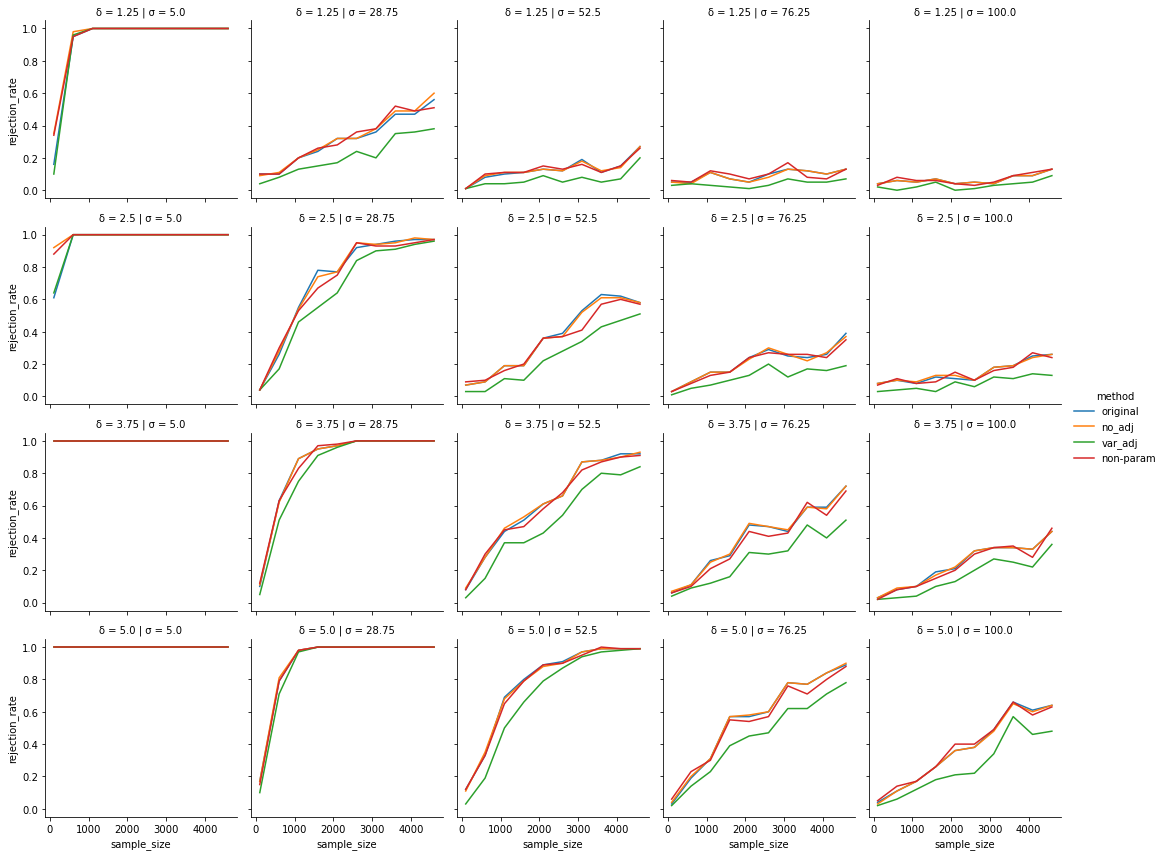

In [173]:
# power
g = sns.FacetGrid(results[results['δ']!=0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

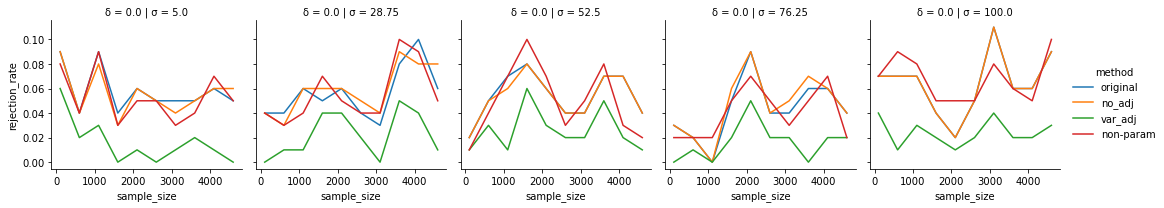

In [174]:
#type I
g = sns.FacetGrid(results[results['δ']==0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

# polynomial regression with gamma-distributed error term

In [337]:
def model_generator(δ, σ, size, n, degree=1):
    beta=np.random.uniform(1,10,size=degree+1)
    X = np.random.normal(loc=0, scale=σ, size=(2, size,n))
    X[1, :, :] += δ
    S=0
    for d in range(degree+1):
        S+=(X**d)*beta[d]
    # error's values are proportional to S, otherwise (Y-S)/Y is too close to 0%
    # you can test any error distribution here
    error=np.random.default_rng().gamma(np.abs(np.mean(S))/5,np.abs(np.mean(S))/2, size=(2, size,n))
    Y=S+error
    return X, S, Y

(array([ 23.,  83., 212., 249., 196., 127.,  68.,  28.,  12.,   2.]),
 array([ 2796.26919574,  3615.06369845,  4433.85820116,  5252.65270386,
         6071.44720657,  6890.24170928,  7709.03621199,  8527.8307147 ,
         9346.6252174 , 10165.41972011, 10984.21422282]),
 <BarContainer object of 10 artists>)

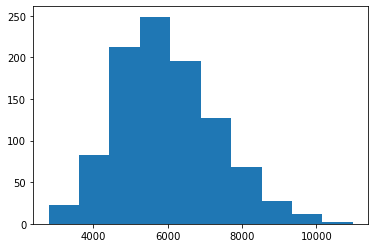

In [323]:
plt.hist(np.random.default_rng().gamma(20, 300, size=1000))

In [342]:
SIGMA = np.linspace(5, 70, 5)
DELTA = np.linspace(0, 5, 5)
SIZE = range(100, 5000, 300)
REPLICATIONS = 100

results_gamma = []
for σ, δ, size in tqdm(product(SIGMA, DELTA, SIZE)):
    rej_rates=find_rejection_rate(δ, σ, size, REPLICATIONS, 3)
    results_gamma.extend([{
        'rejection_rate': rej_rate,
        'σ': σ,
        'δ': δ,
        'sample_size': size,
    } for rej_rate in rej_rates])
    
    

results_gamma = pd.DataFrame(results_gamma)
results_gamma['method']=['original','no_adj','var_adj','non-param']*int(results_gamma.shape[0]/4)

425it [02:18,  3.06it/s]


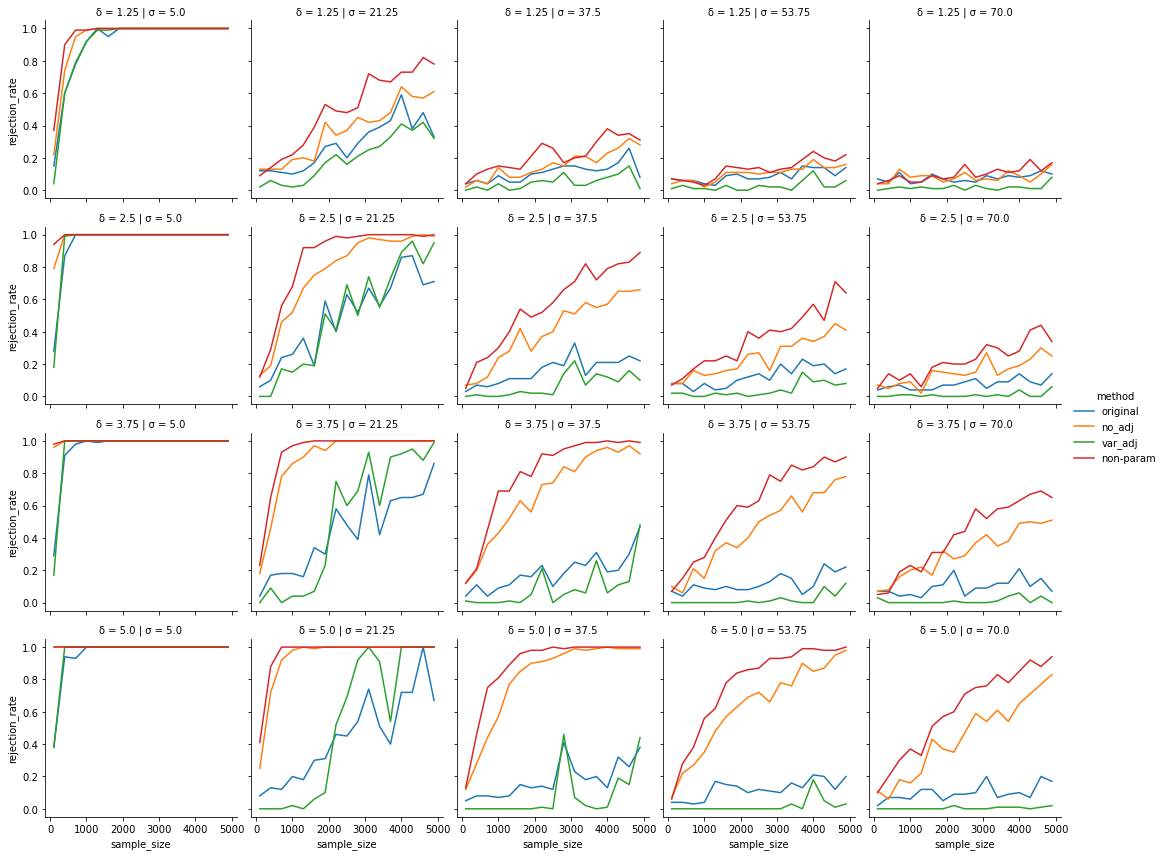

In [344]:
# power
g = sns.FacetGrid(results_gamma[results_gamma['δ']!=0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()

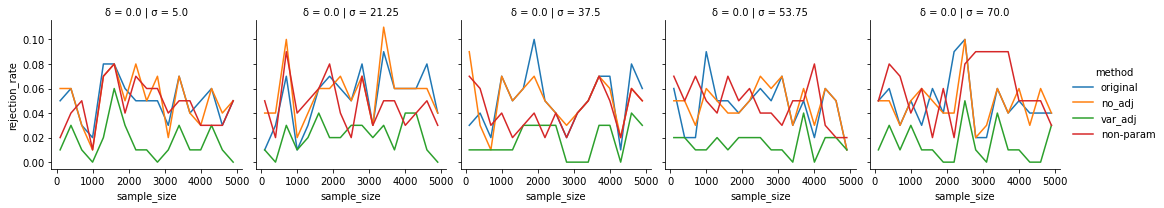

In [345]:
#type I
g = sns.FacetGrid(results_gamma[results_gamma['δ']==0], col="σ",  row="δ",  hue='method')
g.map(sns.lineplot, "sample_size", "rejection_rate")
g.add_legend()